<a href="https://colab.research.google.com/github/elijahmoon-hub/Elijah-s-repository/blob/main/ElijMoonU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [9]:
url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
df = pd.read_csv(url)

In [8]:
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [5]:
url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
df = pd.read_csv(url)

TRB_coords = {"TRB": df['Pos'].unique()}
TRB_idx = df['Pos'].astype('category').cat.codes

# Assuming 'TRB' is the relevant data for your model
# You might need to adjust this based on what 'cs_data.diff_TminusE' represents
cs_data = pd.DataFrame({'TotalRebounds': df['TRB']})

In [ ]:
with pm.Model(coords=TRB_coords) as cs_h_model:
    # Hyperpriors for mu (mean of means)
    μ_mu = pm.StudentT('μ_mu', mu=0, sigma=10, nu=10) # Fixed nu for stability
    μ_sd = pm.HalfStudentT('μ_sd', sigma=10, nu=10) # Fixed nu for stability

    # Prior for group-level means (μ)
    μ = pm.StudentT('μ',
                  mu=μ_mu,
                  sigma=μ_sd,
                  nu=10, # Fixed nu for stability
                  dims="TRB")

    # Prior for group-level standard deviations (σ)
    σ = pm.HalfStudentT('σ', sigma=10,
                      nu=10, # Fixed nu for stability
                      dims="TRB")

    # Likelihood
    y = pm.StudentT('y',
                  mu=μ[TRB_idx],
                  sigma=σ[TRB_idx],
                  nu=10, # Fixed nu for stability for the observed data
                  observed=cs_data['TotalRebounds'])

    idata_cs_h = pm.sample(draws=2000, target_accept=0.95) # Increase draws and target_accept to reduce divergences

In [ ]:
with pm.Model(coords=TRB_coords) as cs_h_model:
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 20)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 20)
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = 20,
                  dims = "TRB")


    σ = pm.HalfStudentT('σ', sigma = 10,
                      nu = 30,
                      dims = "TRB")
    y = pm.StudentT('y',
                  sigma = σ[TRB_idx],
                  mu = μ[TRB_idx],
                  nu = 10,
                  observed = cs_data['TotalRebounds'])

    idata_cs_h = pm.sample(draws=2000, tune=2000, target_accept=0.95, max_treedepth=15)

In [75]:
with pm.Model() as model_halft_priors:
    # Hyperpriors for HalfStudentT sigma parameter
    sigma_hyper_sigma = pm.HalfNormal('sigma_hyper_sigma', sigma=5)

    # Hyperpriors for HalfStudentT nu parameter (degrees of freedom)
    # nu must be greater than 0, so an Exponential or HalfNormal is suitable.
    nu_hyper_lam = pm.Exponential('nu_hyper_lam', lam=1/30)

    # HalfStudentT prior using the defined hyperpriors
    my_halft_prior = pm.HalfStudentT('my_halft_prior',
                                     sigma=sigma_hyper_sigma,
                                     nu=nu_hyper_lam)

    print("Hyperpriors and priors for HalfStudentT defined.")

Hyperpriors and priors for HalfStudentT defined.


In [ ]:
with pm.Model(coords=TRB_coords) as cs_nh_model:
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="TRB")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="TRB")
    y = pm.Normal('y',
                  mu = μ[TRB_idx],
                  sigma = σ[TRB_idx],
                  observed=cs_data['TotalRebounds'])
    idata_cs_nh = pm.sample()

In [77]:
az.rhat(idata_cs_nh)

<xarray.Dataset> Size: 432B
Dimensions:  (TRB: 12)
Coordinates:
  * TRB      (TRB) <U5 240B 'PF-C' 'C' 'SG' 'PF' ... 'PF-SF' 'SF-SG' 'SG-PG'
Data variables:
    μ        (TRB) float64 96B 1.001 1.003 1.006 1.0 ... 1.001 1.001 1.001
    σ        (TRB) float64 96B 0.9999 1.001 1.0 1.006 ... 1.002 0.9998 1.001

I found that rhat value to determine how well the predictions fit. My rhat values are very close to 1 and are optimal for my prediction of total rebounds

array([<Axes: >], dtype=object)

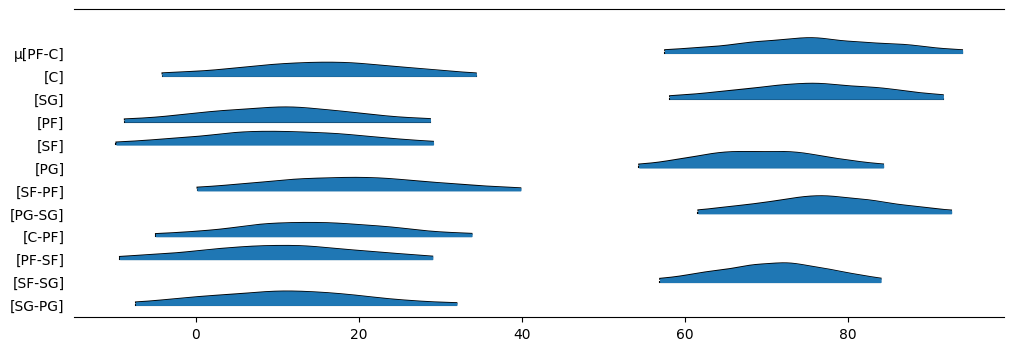

In [86]:
az.plot_forest(idata_cs_nh, var_names=['μ'], combined=True, figsize=(12, 4), kind = 'ridgeplot', hdi_prob=0.95)

I plotted the non heirarchical model which helped me find the mean rebounds for each position. Each position is different from eachother so I made a model that seperates each position and the chance to land in the interval. I chose an HDI of 95%.

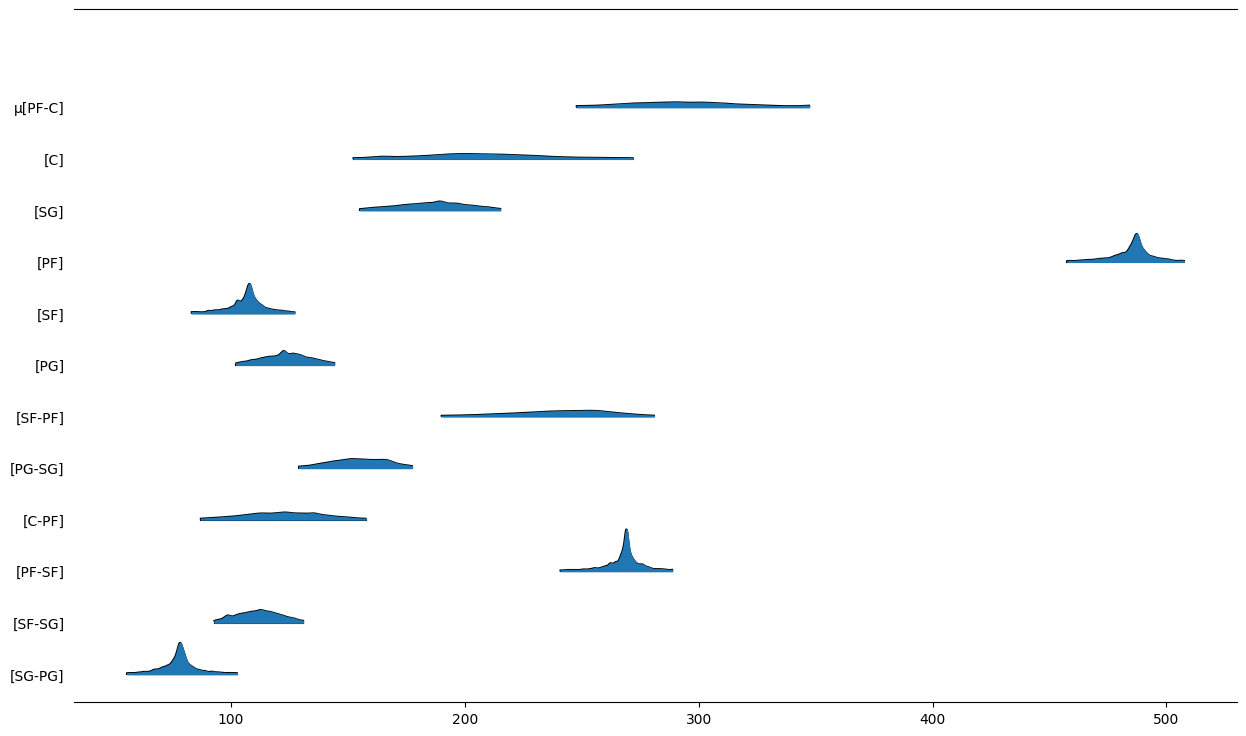

In [87]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(15, 9), hdi_prob=0.95)

This is my heirarchical model for the TRB based upon position. The HDI is 98% meaning there is a 98% probability for to land in the blue region for each position. I increased the figure size to make it larger in order to better portray the shapes of each curve. This helps me figure out if the experiment was predicted well.

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)


#The following code block is taken from the textbook BAP3.
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0,700);


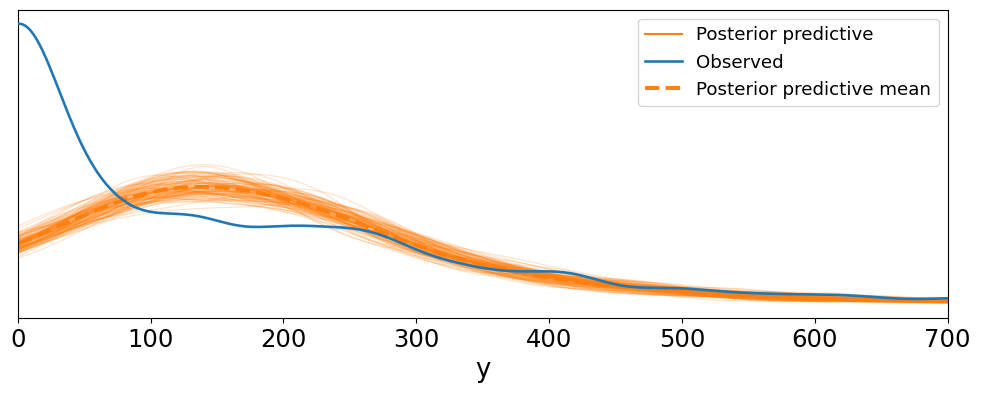

In [96]:
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0,700);

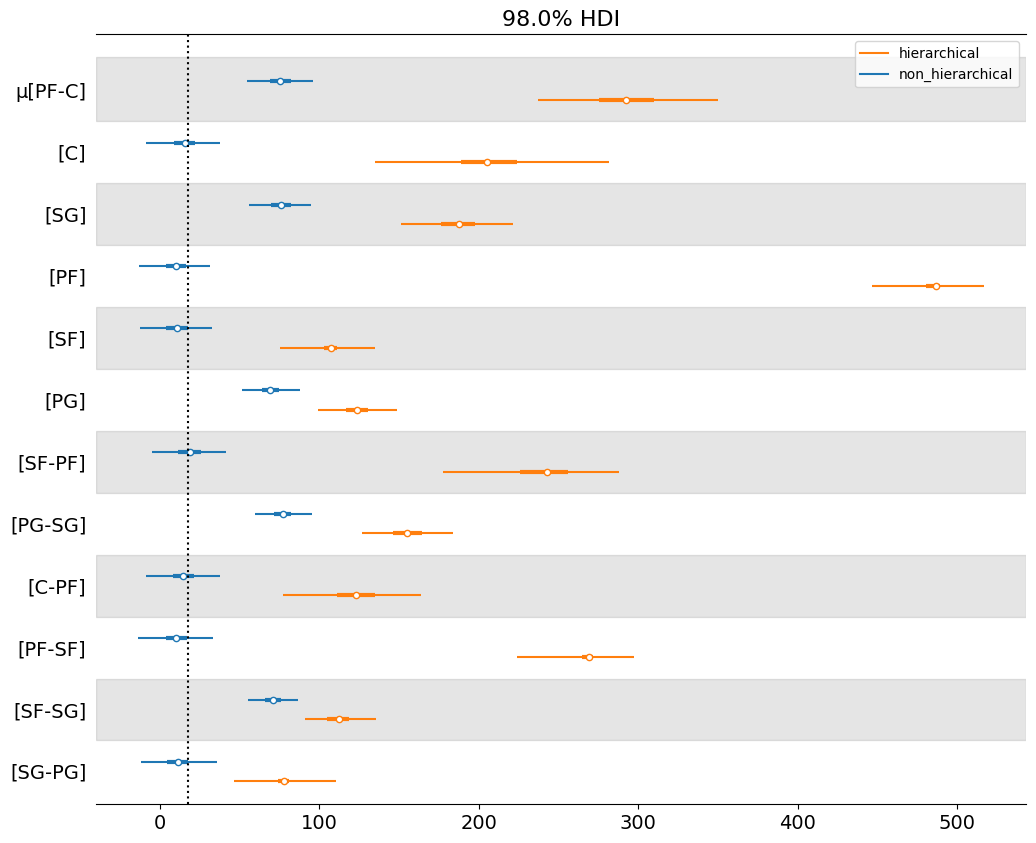

In [89]:
#plots a 98% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.98)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

The hierarchical model shifted the means of the total rebounds of each position towards the mean of the hyperprior. However, it resulted in more variance as most of the hierarchical lines are longer than the non-hierarchical lines.  

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

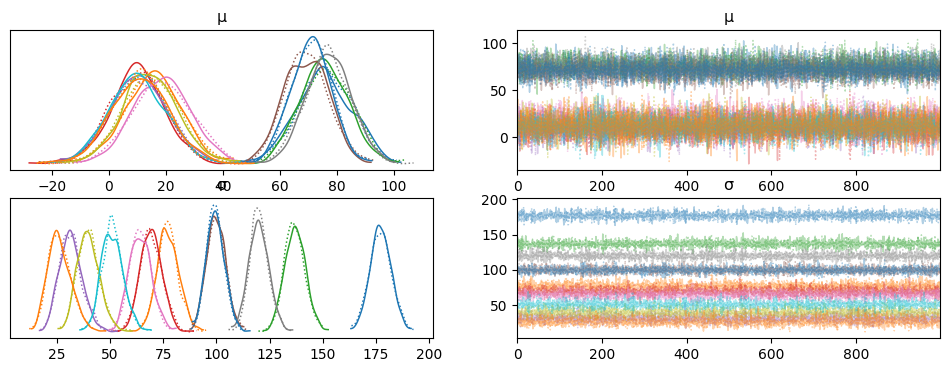

In [90]:
az.plot_trace(idata_cs_nh)

Text(0.5, 1.0, 'Small Forward mean rebounds')

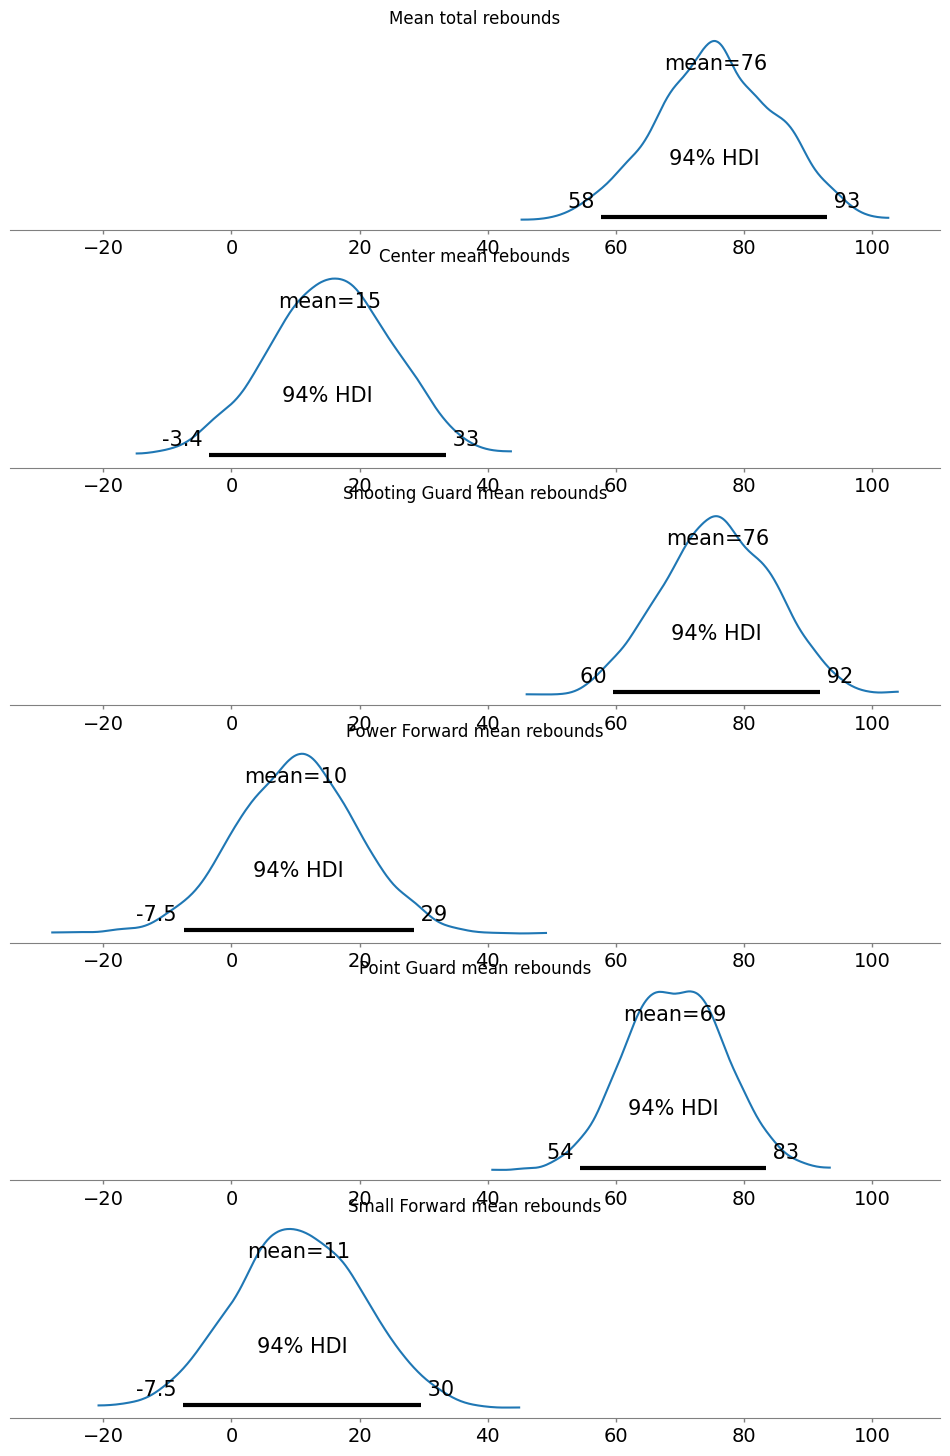

In [83]:
fig, ax = plt.subplots(6, figsize=(12, 18), sharex=True)

az.plot_posterior(idata_cs_nh, var_names='μ', ax=ax[0])
ax[0].set_title(r"Mean total rebounds")

az.plot_posterior(idata_cs_nh.posterior.sel(TRB="C"), var_names='μ', ax=ax[1])
ax[1].set_title(r"Center mean rebounds")

az.plot_posterior(idata_cs_nh.posterior.sel(TRB="SG"), var_names='μ', ax=ax[2])
ax[2].set_title(r"Shooting Guard mean rebounds")

az.plot_posterior(idata_cs_nh.posterior.sel(TRB="PF"), var_names='μ', ax=ax[3])
ax[3].set_title(r"Power Forward mean rebounds")

az.plot_posterior(idata_cs_nh.posterior.sel(TRB="PG"), var_names='μ', ax=ax[4])
ax[4].set_title(r"Point Guard mean rebounds")

az.plot_posterior(idata_cs_nh.posterior.sel(TRB="SF"), var_names='μ', ax=ax[5])
ax[5].set_title(r"Small Forward mean rebounds")

I created a visualization for how the mean total rebounds compared to the mean rebounds of each position. I compared the Center, to Shooting guard, to power forward, to point guard, to small forward. Some positions are much likely than others to get a rebound as they are positioned near the rim. From my predictions, the shooting guard and point guard have the highest average rebounds based on the players given in the data, with a mean of 76. On the other hand, power forwards were the least likely to get rebounds and had the lowest mean rebounds of 10.

# Task
Remove the x-axis limit from the posterior predictive distribution plot in cell `4j6cWU7MQkaY` to allow the full range of the distribution to be displayed, and then evaluate the updated plot.

## Remove x-axis limit from PPC plot

### Subtask:
Modify cell `4j6cWU7MQkaY` by removing or commenting out the line `ax.set_xlim(0,100)` to allow the full range of the posterior predictive distribution to be displayed. Then, execute the modified cell.
